# Atari

`通过这个实验，了解Deep-Q Learning。`

所有的实验源代码都在`lib`目录下，来自[dennybritz](https://github.com/dennybritz/reinforcement-learning)，这里只做解读和归总。

## 实验目录

- [Gridworld](https://applenob.github.io/gridworld.html)：对应MDP的Dynamic Programming
- [Blackjack](https://applenob.github.io/black_jack.html)：对应Model Free的Monte Carlo的Planning和Controlling
- [Windy Gridworld](https://applenob.github.io/windy_gridworld.html)：对应Model Free的Temporal Difference的On-Policy Controlling，SARSA。
- [Cliff Walking](https://applenob.github.io/cliff_walking.html)：对应Model Free的Temporal Difference的Off-Policy Controlling，Q-learning。
- [Mountain Car](https://applenob.github.io/mountain_car.html)：对应Q-Learning with Linear Function Approximation。
- [Atari](https://applenob.github.io/atari.html)：对应Deep-Q Learning。


## 本文目录

- [问题介绍](#问题介绍)
- [Deep Q-Networks](#Deep-Q-Networks)

## 问题介绍

这是一个常见的手机游戏，在游戏开始的时候fire出一个球，去把上方的砖块一块块击碎，每击碎一块加一分。球会一直按照直线运动，碰到边界或者砖块会反弹。如果球到了下方的边界，则损失一条命，一共五条命。agent需要在球落到下方的边界之前，赶到那个地方，将其反弹。

- 动作集：noop（空操作），fire，left，right。


In [1]:
%matplotlib inline

import gym
from gym.wrappers import Monitor
import itertools
import numpy as np
import os
import random
import sys
import psutil
import tensorflow as tf

from lib import plotting
from collections import deque, namedtuple
from matplotlib import pyplot as plt

使用之前，要先单独安装atari：`pip install gym[atari]`

In [2]:
env = gym.envs.make("Breakout-v0")

[2017-10-04 17:08:31,130] Making new env: Breakout-v0


In [3]:
# Atari Actions: 0 (noop), 1 (fire), 2 (left) and 3 (right) are valid actions
VALID_ACTIONS = [0, 1, 2, 3]
print("Action space size: {}".format(env.action_space.n))

Action space size: 4


Observation space shape: (210, 160, 3)


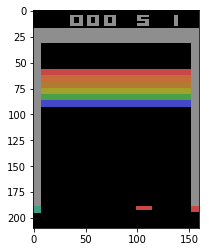

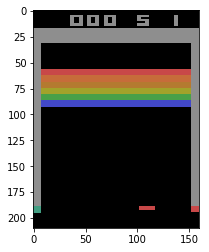

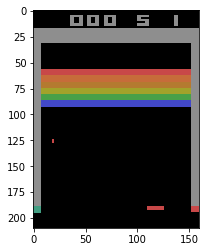

In [4]:
observation = env.reset()
print("Observation space shape: {}".format(observation.shape))

plt.figure()
plt.imshow(env.render(mode='rgb_array'))

env.step(2)
plt.figure()
plt.imshow(env.render(mode='rgb_array'))

env.step(1)
plt.figure()
plt.imshow(env.render(mode='rgb_array'))

env.render(close=True)

(160, 160, 3)


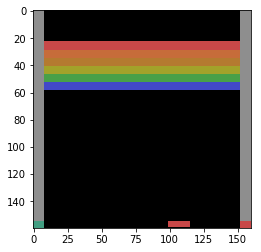

In [5]:
print(observation[34:-16,:,:].shape) # 210 - 34 - 16 = 160
plt.imshow(observation[34:-16,:,:])

In [6]:
class StateProcessor():
    """
    Processes a raw Atari iamges. Resizes it and converts it to grayscale.
    图片的预处理。
    """
    def __init__(self):
        # Build the Tensorflow graph
        with tf.variable_scope("state_processor"):
            self.input_state = tf.placeholder(shape=[210, 160, 3], dtype=tf.uint8)
            self.output = tf.image.rgb_to_grayscale(self.input_state)
            self.output = tf.image.crop_to_bounding_box(self.output, 34, 0, 160, 160)
            self.output = tf.image.resize_images(
                self.output, [84, 84], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            self.output = tf.squeeze(self.output)

    def process(self, sess, state):
        """
        Args:
            sess: A Tensorflow session object
            state: A [210, 160, 3] Atari RGB State

        Returns:
            A processed [84, 84, 1] state representing grayscale values.
        """
        return sess.run(self.output, { self.input_state: state })

## Deep Q-Networks

**带经验回放的DQN（Experience Replay in Deep Q-Networks）**：
- 1.使用$\epsilon-greedy$在policy中选择动作$a_t$。
- 2.保存$(s_t, a_t, r_{t+1}, s_{t+1})$到回放记忆$D$。
- 3.从$D$中抽一个mini-batch：$(s, a, r, s')$。
- 4.使用老参数$w^-$计算Q-learning target（fixed Q-learning target）。
- 5.优化Q-network和Q-learning之间的MSE：$L_i(w) = E_{s, a, r, s' \sim D_i}[(r + \gamma \underset{a'}{max}Q(s', a'; w_i^-))^2]$
- 两个Trick：**经验回放Experience Replay**，**fixed Q-learning target**。

In [7]:
class Estimator():
    """Q-Value Estimator neural network.

    This network is used for both the Q-Network and the Target Network.
    """

    def __init__(self, scope="estimator", summaries_dir=None):
        self.scope = scope
        # Writes Tensorboard summaries to disk
        self.summary_writer = None
        with tf.variable_scope(scope):
            # Build the graph
            self._build_model()
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.summary.FileWriter(summary_dir)

    def _build_model(self):
        """
        Builds the Tensorflow graph.
        """

        # Placeholders for our input
        # Our input are 4 RGB frames of shape 160, 160 each
        # 不需要再提取其他特征，使用图片与处理之后的像素点作为特征
        self.X_pl = tf.placeholder(shape=[None, 84, 84, 4], dtype=tf.uint8, name="X")
        # The TD target value
        self.y_pl = tf.placeholder(shape=[None], dtype=tf.float32, name="y")
        # Integer id of which action was selected
        self.actions_pl = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")

        X = tf.to_float(self.X_pl) / 255.0
        batch_size = tf.shape(self.X_pl)[0]

        # Three convolutional layers
        conv1 = tf.contrib.layers.conv2d(
            X, 32, 8, 4, activation_fn=tf.nn.relu)
        conv2 = tf.contrib.layers.conv2d(
            conv1, 64, 4, 2, activation_fn=tf.nn.relu)
        conv3 = tf.contrib.layers.conv2d(
            conv2, 64, 3, 1, activation_fn=tf.nn.relu)

        # Fully connected layers
        flattened = tf.contrib.layers.flatten(conv3)
        fc1 = tf.contrib.layers.fully_connected(flattened, 512)
        # 输出是不同的动作对应的TD-target
        self.predictions = tf.contrib.layers.fully_connected(fc1, len(VALID_ACTIONS))

        # Get the predictions for the chosen actions only
        gather_indices = tf.range(batch_size) * tf.shape(self.predictions)[1] + self.actions_pl
        self.action_predictions = tf.gather(tf.reshape(self.predictions, [-1]), gather_indices)

        # Calcualte the loss
        self.losses = tf.squared_difference(self.y_pl, self.action_predictions)
        self.loss = tf.reduce_mean(self.losses)

        # Optimizer Parameters from original paper
        self.optimizer = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6)
        self.train_op = self.optimizer.minimize(self.loss, global_step=tf.contrib.framework.get_global_step())

        # Summaries for Tensorboard
        self.summaries = tf.summary.merge([
            tf.summary.scalar("loss", self.loss),
            tf.summary.histogram("loss_hist", self.losses),
            tf.summary.histogram("q_values_hist", self.predictions),
            tf.summary.scalar("max_q_value", tf.reduce_max(self.predictions))
        ])

    def predict(self, sess, s):
        """
        Predicts action values.

        Args:
          sess: Tensorflow session
          s: State input of shape [batch_size, 4, 160, 160, 3]

        Returns:
          Tensor of shape [batch_size, NUM_VALID_ACTIONS] containing the estimated 
          action values.
        """
        return sess.run(self.predictions, { self.X_pl: s })

    def update(self, sess, s, a, y):
        """
        Updates the estimator towards the given targets.

        Args:
          sess: Tensorflow session object
          s: State input of shape [batch_size, 4, 160, 160, 3]
          a: Chosen actions of shape [batch_size]
          y: Targets of shape [batch_size]

        Returns:
          The calculated loss on the batch.
        """
        feed_dict = { self.X_pl: s, self.y_pl: y, self.actions_pl: a }
        summaries, global_step, _, loss = sess.run(
            [self.summaries, tf.contrib.framework.get_global_step(), self.train_op, self.loss],
            feed_dict)
        if self.summary_writer:
            self.summary_writer.add_summary(summaries, global_step)
        return loss

In [8]:
# For Testing....

tf.reset_default_graph()
global_step = tf.Variable(0, name="global_step", trainable=False)

e = Estimator(scope="test")
sp = StateProcessor()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Example observation batch
    observation = env.reset()
    
    observation_p = sp.process(sess, observation)
    observation = np.stack([observation_p] * 4, axis=2)
    observations = np.array([observation] * 2)
    
    # Test Prediction
    print(e.predict(sess, observations))

    # Test training step
    y = np.array([10.0, 10.0])
    a = np.array([1, 3])
    print(e.update(sess, observations, a, y))

/home/cer/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[[ 0.          0.          0.06056029  0.00708057]
 [ 0.          0.          0.06056029  0.00708057]]
99.9292


In [9]:
class ModelParametersCopier():
    """
    Copy model parameters of one estimator to another.
    """
    
    def __init__(self, estimator1, estimator2):
        """
        Defines copy-work operation graph.  
        Args:
          estimator1: Estimator to copy the paramters from
          estimator2: Estimator to copy the parameters to
        """
        e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.scope)]
        e1_params = sorted(e1_params, key=lambda v: v.name)
        e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.scope)]
        e2_params = sorted(e2_params, key=lambda v: v.name)

        self.update_ops = []
        for e1_v, e2_v in zip(e1_params, e2_params):
            op = e2_v.assign(e1_v)
            self.update_ops.append(op)
            
    def make(self, sess):
        """
        Makes copy.
        Args:
            sess: Tensorflow session instance
        """
        sess.run(self.update_ops)

In [10]:
def make_epsilon_greedy_policy(estimator, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.

    Args:
        estimator: An estimator that returns q values for a given state
        nA: Number of actions in the environment.

    Returns:
        A function that takes the (sess, observation, epsilon) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(sess, observation, epsilon):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(sess, np.expand_dims(observation, 0))[0]
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [11]:
def deep_q_learning(sess,
                    env,
                    q_estimator,
                    target_estimator,
                    state_processor,
                    num_episodes,
                    experiment_dir,
                    replay_memory_size=500000,
                    replay_memory_init_size=50000,
                    update_target_estimator_every=10000,
                    discount_factor=0.99,
                    epsilon_start=1.0,
                    epsilon_end=0.1,
                    epsilon_decay_steps=500000,
                    batch_size=32,
                    record_video_every=50):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.

    Args:
        sess: Tensorflow Session object
        env: OpenAI environment
        q_estimator: Estimator object used for the q values
        target_estimator: Estimator object used for the targets
        state_processor: A StateProcessor object
        num_episodes: Number of episodes to run for
        experiment_dir: Directory to save Tensorflow summaries in
        replay_memory_size: Size of the replay memory
        replay_memory_init_size: Number of random experiences to sampel when initializing 
          the reply memory.
        update_target_estimator_every: Copy parameters from the Q estimator to the 
          target estimator every N steps
        discount_factor: Lambda time discount factor
        epsilon_start: Chance to sample a random action when taking an action.
          Epsilon is decayed over time and this is the start value
        epsilon_end: The final minimum value of epsilon after decaying is done
        epsilon_decay_steps: Number of steps to decay epsilon over
        batch_size: Size of batches to sample from the replay memory
        record_video_every: Record a video every N episodes

    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

    # The replay memory
    replay_memory = []
    
    # Make model copier object
    estimator_copy = ModelParametersCopier(q_estimator, target_estimator)

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    # For 'system/' summaries, usefull to check if currrent process looks healthy
    current_process = psutil.Process()

    # Create directories for checkpoints and summaries
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    checkpoint_path = os.path.join(checkpoint_dir, "model")
    monitor_path = os.path.join(experiment_dir, "monitor")
    
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    if not os.path.exists(monitor_path):
        os.makedirs(monitor_path)

    saver = tf.train.Saver()
    # Load a previous checkpoint if we find one
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print("Loading model checkpoint {}...\n".format(latest_checkpoint))
        saver.restore(sess, latest_checkpoint)
    
    # Get the current time step
    total_t = sess.run(tf.contrib.framework.get_global_step())

    # The epsilon decay schedule
    epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)

    # The policy we're following
    policy = make_epsilon_greedy_policy(
        q_estimator,
        len(VALID_ACTIONS))

    # Populate the replay memory with initial experience
    print("Populating replay memory...")
    state = env.reset()
    state = state_processor.process(sess, state)
    state = np.stack([state] * 4, axis=2)
    for i in range(replay_memory_init_size):
        # 1.使用epsilon-greedy在policy中选择动作a_t。
        action_probs = policy(sess, state, epsilons[min(total_t, epsilon_decay_steps-1)])
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        next_state, reward, done, _ = env.step(VALID_ACTIONS[action])
        next_state = state_processor.process(sess, next_state)
        next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)
        # 2.保存(s_t, a_t, r_{t+1}, s_{t+1})到回放记忆D。
        replay_memory.append(Transition(state, action, reward, next_state, done))
        if done:
            state = env.reset()
            state = state_processor.process(sess, state)
            state = np.stack([state] * 4, axis=2)
        else:
            state = next_state


    # Record videos
    # Add env Monitor wrapper
    env = Monitor(env, directory=monitor_path, video_callable=lambda count: count % record_video_every == 0, resume=True)

    for i_episode in range(num_episodes):

        # Save the current checkpoint
        saver.save(tf.get_default_session(), checkpoint_path)

        # Reset the environment
        state = env.reset()
        state = state_processor.process(sess, state)
        state = np.stack([state] * 4, axis=2)
        loss = None

        # One step in the environment
        for t in itertools.count():

            # Epsilon for this time step
            epsilon = epsilons[min(total_t, epsilon_decay_steps-1)]

            # Maybe update the target estimator
            if total_t % update_target_estimator_every == 0:
                estimator_copy.make(sess)
                print("\nCopied model parameters to target network.")

            # Print out which step we're on, useful for debugging.
            if t % 10 == 0:
                print("\rStep {} ({}) @ Episode {}/{}, loss: {}".format(
                    t, total_t, i_episode + 1, num_episodes, loss), end="")
                sys.stdout.flush()

            # Take a step
            action_probs = policy(sess, state, epsilon)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(VALID_ACTIONS[action])
            next_state = state_processor.process(sess, next_state)
            next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)

            # If our replay memory is full, pop the first element
            if len(replay_memory) == replay_memory_size:
                replay_memory.pop(0)

            # Save transition to replay memory
            # 更新回放记忆
            replay_memory.append(Transition(state, action, reward, next_state, done))   

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # Sample a minibatch from the replay memory
            # 3.从D中抽一个mini-batch：(s, a, r, s')。
            samples = random.sample(replay_memory, batch_size)
            states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))

            # Calculate q values and targets
            # 4.使用老参数w计算Q-learning target（fixed Q-learning target）。
            q_values_next = target_estimator.predict(sess, next_states_batch)
            targets_batch = reward_batch + np.invert(done_batch).astype(np.float32) * discount_factor * np.amax(q_values_next, axis=1)

            # Perform gradient descent update
            # 5.优化Q-network和Q-learning之间的MSE
            states_batch = np.array(states_batch)
            loss = q_estimator.update(sess, states_batch, action_batch, targets_batch)

            if done:
                break

            state = next_state
            total_t += 1

        # Add summaries to tensorboard
        episode_summary = tf.Summary()
        episode_summary.value.add(simple_value=epsilon, tag="episode/epsilon")
        episode_summary.value.add(simple_value=stats.episode_rewards[i_episode], tag="episode/reward")
        episode_summary.value.add(simple_value=stats.episode_lengths[i_episode], tag="episode/length")
        episode_summary.value.add(simple_value=current_process.cpu_percent(), tag="system/cpu_usage_percent")
        episode_summary.value.add(simple_value=current_process.memory_percent(memtype="vms"), tag="system/v_memeory_usage_percent")
        q_estimator.summary_writer.add_summary(episode_summary, i_episode)
        q_estimator.summary_writer.flush()
        
        yield total_t, plotting.EpisodeStats(
            episode_lengths=stats.episode_lengths[:i_episode+1],
            episode_rewards=stats.episode_rewards[:i_episode+1])

    return stats

In [13]:
tf.reset_default_graph()

# Where we save our checkpoints and graphs
experiment_dir = os.path.abspath("./experiments/{}".format(env.spec.id))

# Create a glboal step variable
global_step = tf.Variable(0, name='global_step', trainable=False)
    
# Create estimators
q_estimator = Estimator(scope="q_estimator", summaries_dir=experiment_dir)
target_estimator = Estimator(scope="target_q")

# State processor
state_processor = StateProcessor()

# Run it!
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    count_ = 0
    for t, stats in deep_q_learning(sess,
                                    env,
                                    q_estimator=q_estimator,
                                    target_estimator=target_estimator,
                                    state_processor=state_processor,
                                    experiment_dir=experiment_dir,
                                    num_episodes=100,
                                    replay_memory_size=500000,
                                    replay_memory_init_size=50000,
                                    update_target_estimator_every=10000,
                                    epsilon_start=1.0,
                                    epsilon_end=0.1,
                                    epsilon_decay_steps=500000,
                                    discount_factor=0.99,
                                    batch_size=32):

        if count_ % 10 == 0:
            print("\nEpisode Reward: {}".format(stats.episode_rewards[-1]))
        count_ += 1

/home/cer/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Loading model checkpoint /home/cer/Project/from_github/rl_learn/experiments/Breakout-v0/checkpoints/model...

Populating replay memory...


[2017-10-04 19:02:10,666] Starting new video recorder writing to /home/cer/Project/from_github/rl_learn/experiments/Breakout-v0/monitor/openaigym.video.1.3971.video000000.mp4


Step 300 (44874) @ Episode 1/100, loss: 0.0029317396692931652
Episode Reward: 3.0
Step 160 (47175) @ Episode 11/100, loss: 0.0386776886880397858
Episode Reward: 0.0
Step 170 (49841) @ Episode 21/100, loss: 0.00122361839748919164
Episode Reward: 0.0
Step 150 (49995) @ Episode 22/100, loss: 0.0017673487309366465
Copied model parameters to target network.
Step 170 (52066) @ Episode 31/100, loss: 0.0017162094591185454
Episode Reward: 0.0
Step 210 (54363) @ Episode 41/100, loss: 0.0060867369174957275
Episode Reward: 1.0
Step 360 (56798) @ Episode 50/100, loss: 0.0476472973823547365

[2017-10-04 19:37:34,330] Starting new video recorder writing to /home/cer/Project/from_github/rl_learn/experiments/Breakout-v0/monitor/openaigym.video.1.3971.video000050.mp4


Step 340 (57138) @ Episode 51/100, loss: 0.0021206371020525694
Episode Reward: 3.0
Step 370 (59920) @ Episode 61/100, loss: 0.03912981599569321355
Episode Reward: 4.0
Step 70 (59999) @ Episode 62/100, loss: 0.0012430942151695495
Copied model parameters to target network.
Step 160 (62398) @ Episode 71/100, loss: 0.00104279548395425085
Episode Reward: 0.0
Step 170 (65048) @ Episode 81/100, loss: 0.00226859888061881077
Episode Reward: 0.0
Step 290 (67996) @ Episode 91/100, loss: 0.00119913835078477862
Episode Reward: 2.0
Step 0 (69991) @ Episode 99/100, loss: None00132140703499317175
Copied model parameters to target network.
Step 160 (70380) @ Episode 100/100, loss: 0.0230728760361671459

[2017-10-04 20:19:02,569] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/cer/Project/from_github/rl_learn/experiments/Breakout-v0/monitor')
